In [1]:
%matplotlib inline
import pandas as pd
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

import players
player_names = list(map(str, players.players))
number_of_digits = 3  # Number of digits to round for LaTeX tables

turns = 200
number_of_players = len(player_names)

assert number_of_players == 176

def clean_latex(string):
    """Replace some special carachters"""
    string = string.replace("textbackslashpi", "pi")
    string = string.replace("textbackslashphi", "phi")
    string = string.replace("\\$", "$")
    string = string.replace("\\$", "$")
    string = string.replace("\\textasciicircum", "^")
    string = string.replace("\_", "_")
    string = string.replace("2_2_2", "2\_2\_2")
    string = string.replace("1_1_1", "1\_1\_1")
    return string

# Study the standard tournaments

## Scores

In [2]:
def read_scores(files):
    dfs = []
    for gz in files:
        if "scores" in gz:
            dfs.append(pd.read_csv(gz, header=None, names=player_names))
    df = pd.concat(dfs)
    df /= turns * (number_of_players - 1)  # Scale all scores
    return df

In [3]:
standard_files = glob.glob("./data/*_0_1000*gz")
scores = read_scores(files=standard_files)

In [4]:
def summarise_scores(scores):
    df = scores.describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("50%", ascending=False)  # Sorted on the median
    df["count"] = df["count"].astype(int)
    return df

score_summary = summarise_scores(scores)
score_summary.head(15)

,count,mean,std,min,5%,25%,50%,75%,95%,max
EvolvedLookerUp2_2_2,15000,2.954937,0.010394,2.915457,2.936941,2.948000,2.955514,2.962571,2.970943,2.984286
Evolved HMM 5,15000,2.954333,0.013890,2.903257,2.931284,2.944707,2.954357,2.964057,2.976829,3.002743
Evolved FSM 16,15000,2.952436,0.013192,2.900371,2.929656,2.943543,2.953086,2.961943,2.973057,2.993171
PSO Gambler 2_2_2,15000,2.938380,0.013361,2.885514,2.913314,2.929857,2.940257,2.948400,2.957200,2.971343
Evolved FSM 16 Noise 05,15000,2.918978,0.012610,2.874286,2.898083,2.910429,2.919014,2.927600,2.939629,2.960943
PSO Gambler 1_1_1,15000,2.911675,0.023403,2.809600,2.872971,2.895943,2.912086,2.927457,2.950057,3.011857
Evolved ANN 5,15000,2.911783,0.010177,2.872743,2.894400,2.904829,2.912057,2.919314,2.927771,2.944114
Evolved FSM 4,15000,2.909684,0.012060,2.868343,2.889314,2.901229,2.910229,2.918521,2.928516,2.941857
Evolved ANN,15000,2.907322,0.010036,2.865457,2.890600,2.900514,2.907543,2.914486,2.923457,2.941629
PSO Gambler Mem1,15000,2.901336,0.025270,2.794314,2.858741,2.884343,2.901771,2.918771,2.942314,2.983543


In [5]:
# Write the top 15 players to a tex table
with open("../assets/standard_top_15_scores_summary.tex", "w") as f:
    f.write(clean_latex(score_summary.head(15).round(number_of_digits).to_latex()))

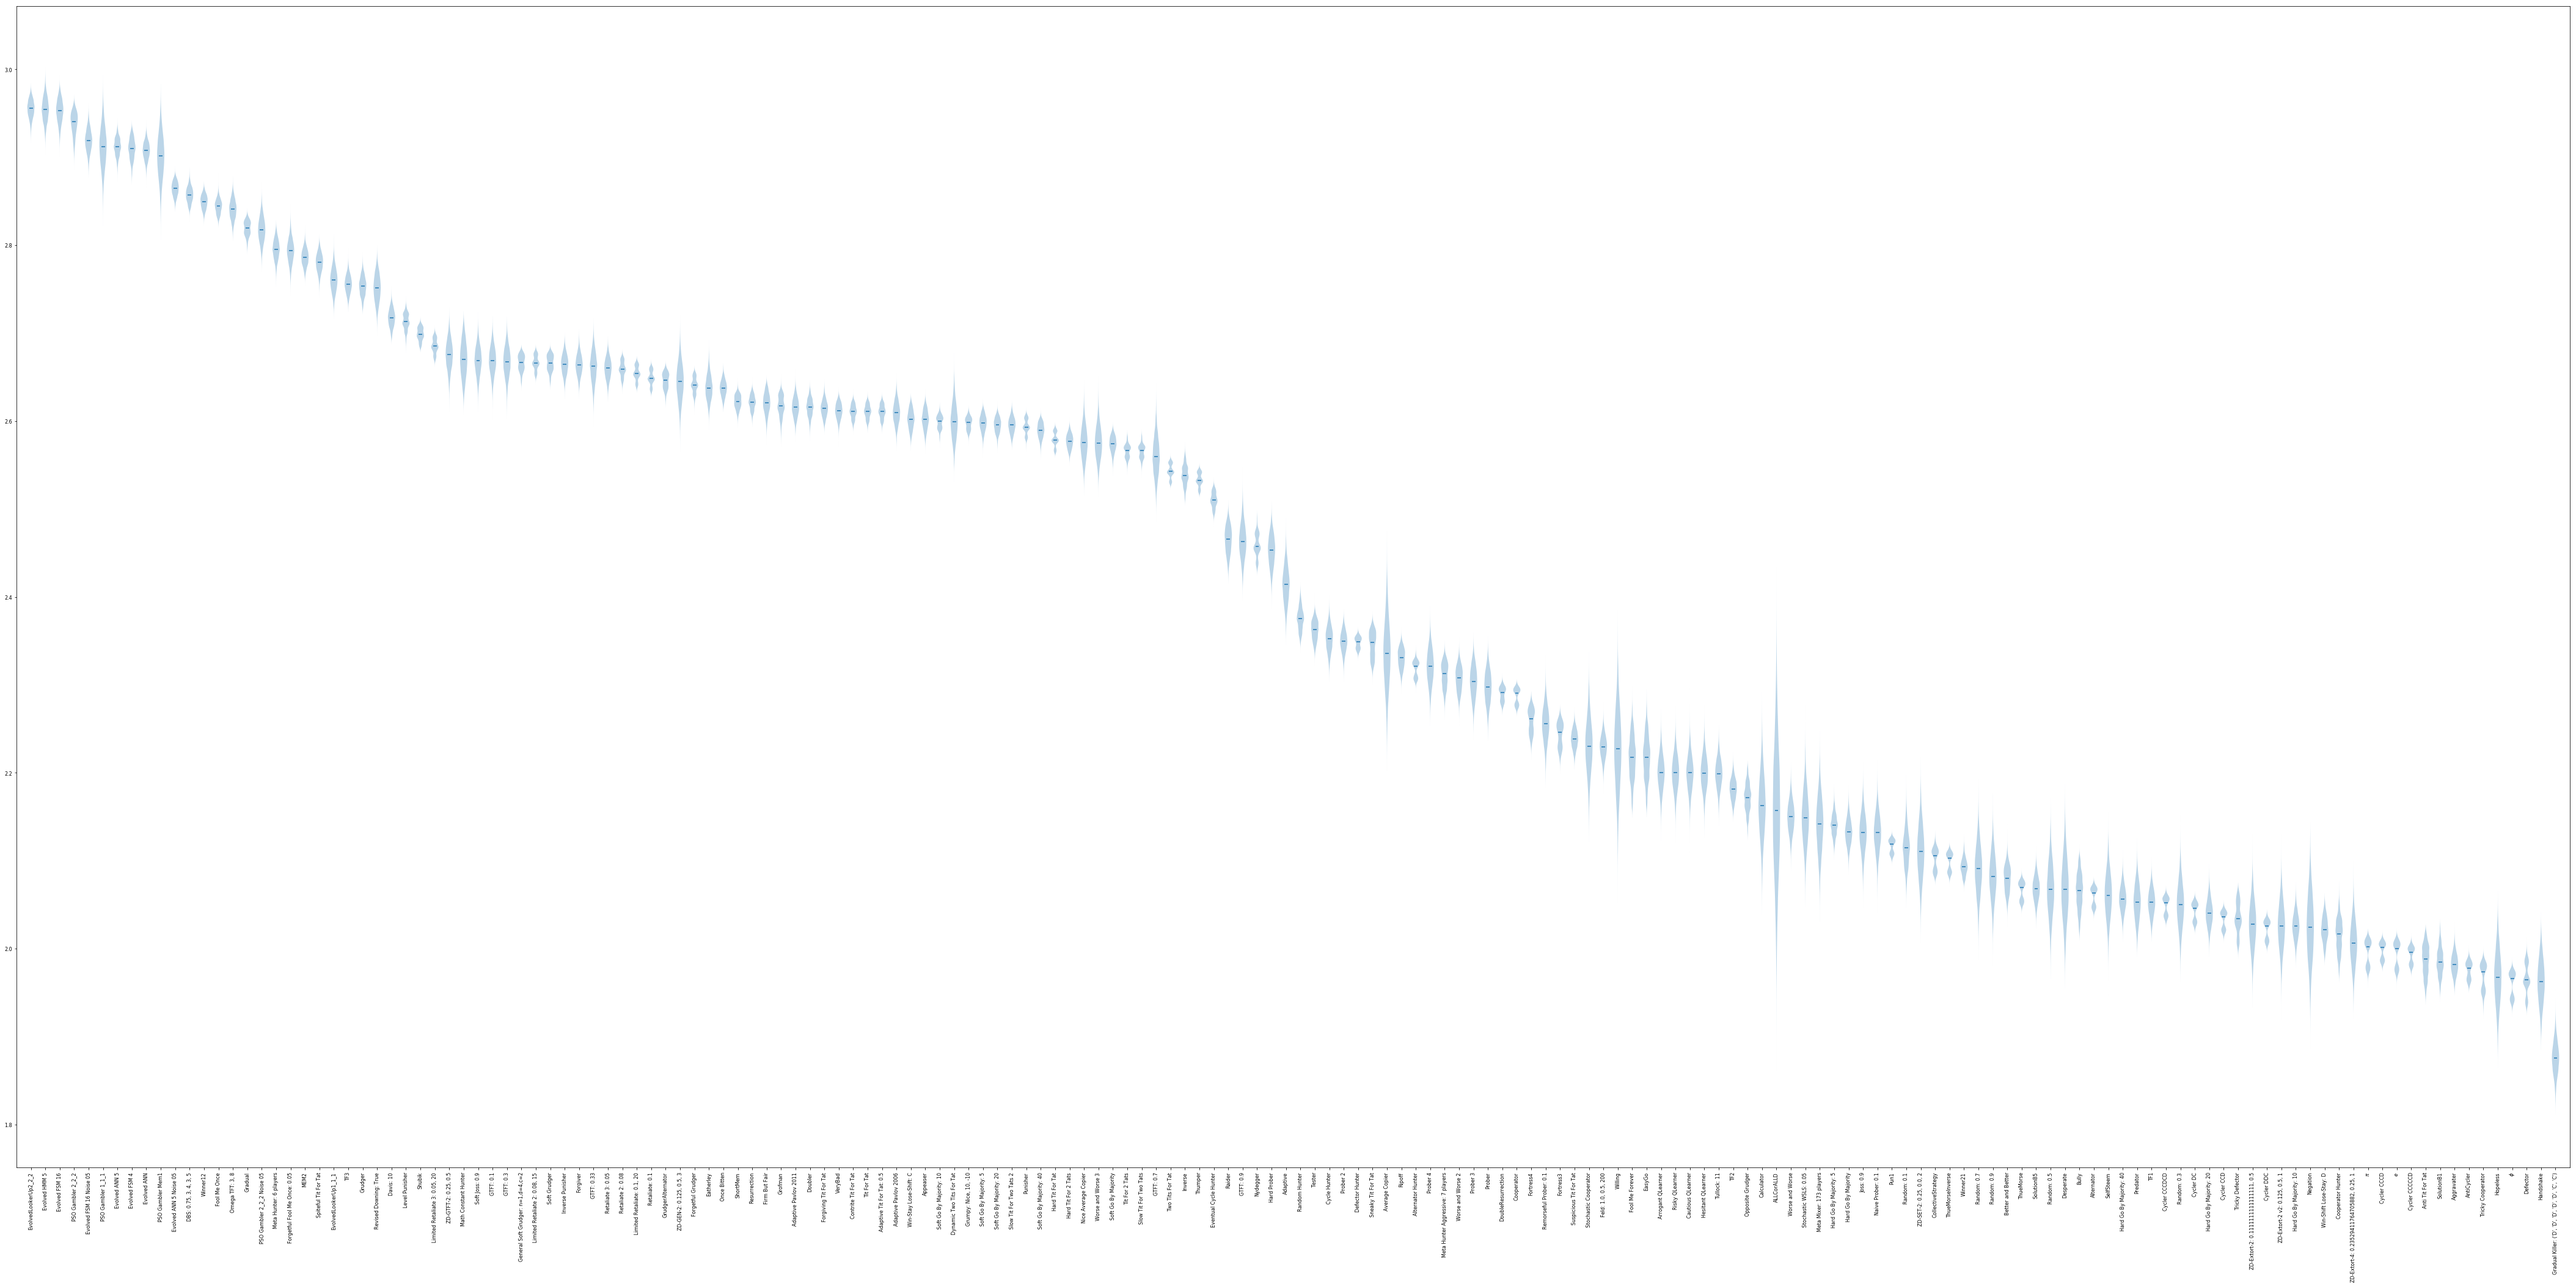

In [6]:
def violon_plot(scores, filename):
    fig, ax = plt.subplots()
    width = number_of_players / 3
    height = width / 2 
    spacing = 4 
    positions = spacing * np.arange(1, number_of_players + 1, 1)
    fig.set_size_inches(width, height) 

    ax.violinplot([scores[player] for player in score_summary.index],
                  positions=positions, widths=spacing / 2,
                  showmedians=True, showextrema=False)
    ax.set_xticks(positions) 
    ax.set_xticklabels(score_summary.index, rotation=90)
    ax.set_xlim([0, spacing * (number_of_players + 1)])
    ax.tick_params(axis='both', which='both', labelsize=8)
    fig.tight_layout()
    fig.savefig(filename);
    
violon_plot(scores, "../assets/standard_scores_boxplots.pdf")

## Ranks

Every row corresponds to a tournament. We can see the ranks of each strategy across the tournament repetitions.

In [7]:
def summarise_ranks(scores):
    df = scores.rank(axis=1, ascending=False).describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("mean")
    for var in ["count", "min", "max"]:
        df[var] = df[var].astype(int)
    return df

rank_summary = summarise_ranks(scores)
rank_summary.head(15)

,count,mean,std,min,5%,25%,50%,75%,95%,max
EvolvedLookerUp2_2_2,15000,2.180700,1.067914,1,1.0,1.0,2.0,3.0,4.0,7
Evolved HMM 5,15000,2.323400,1.271739,1,1.0,1.0,2.0,3.0,5.0,9
Evolved FSM 16,15000,2.472500,1.296690,1,1.0,1.0,2.0,3.0,5.0,9
PSO Gambler 2_2_2,15000,3.969100,1.538176,1,2.0,3.0,4.0,5.0,7.0,10
Evolved FSM 16 Noise 05,15000,6.301300,1.698301,1,4.0,5.0,6.0,7.0,9.0,11
PSO Gambler 1_1_1,15000,7.117900,2.502006,1,3.0,5.0,7.0,9.0,10.0,16
Evolved ANN 5,15000,7.278200,1.524793,2,5.0,6.0,7.0,8.0,10.0,11
Evolved FSM 4,15000,7.521033,1.628399,2,5.0,6.0,8.0,9.0,10.0,12
Evolved ANN,15000,7.890367,1.464652,2,5.0,7.0,8.0,9.0,10.0,12
PSO Gambler Mem1,15000,8.209800,2.525802,1,4.0,6.0,9.0,10.0,12.0,18


In [8]:
# Write the top 15 players to a tex table
with open("../assets/standard_top_15_ranks_summary.tex", "w") as f:
    f.write(clean_latex(rank_summary.head(15).round(number_of_digits).to_latex()))

## Payoff matrix

As all the individual payoff matrix files have the mean values and they all have the same number of repetitions, the mean of the means is the mean over all tournaments.

In [9]:
def read_payoff_matrix(files):
    arrays = []
    for gz in files:
        if "payoff_matrix" in gz:
            arrays.append(np.array(pd.read_csv(gz, header=None)))  # Read through pd to deal with float conversion
    return sum(arrays) / len(arrays)

In [10]:
payoff_matrix = read_payoff_matrix(files=standard_files)
assert payoff_matrix.shape == (176, 176)

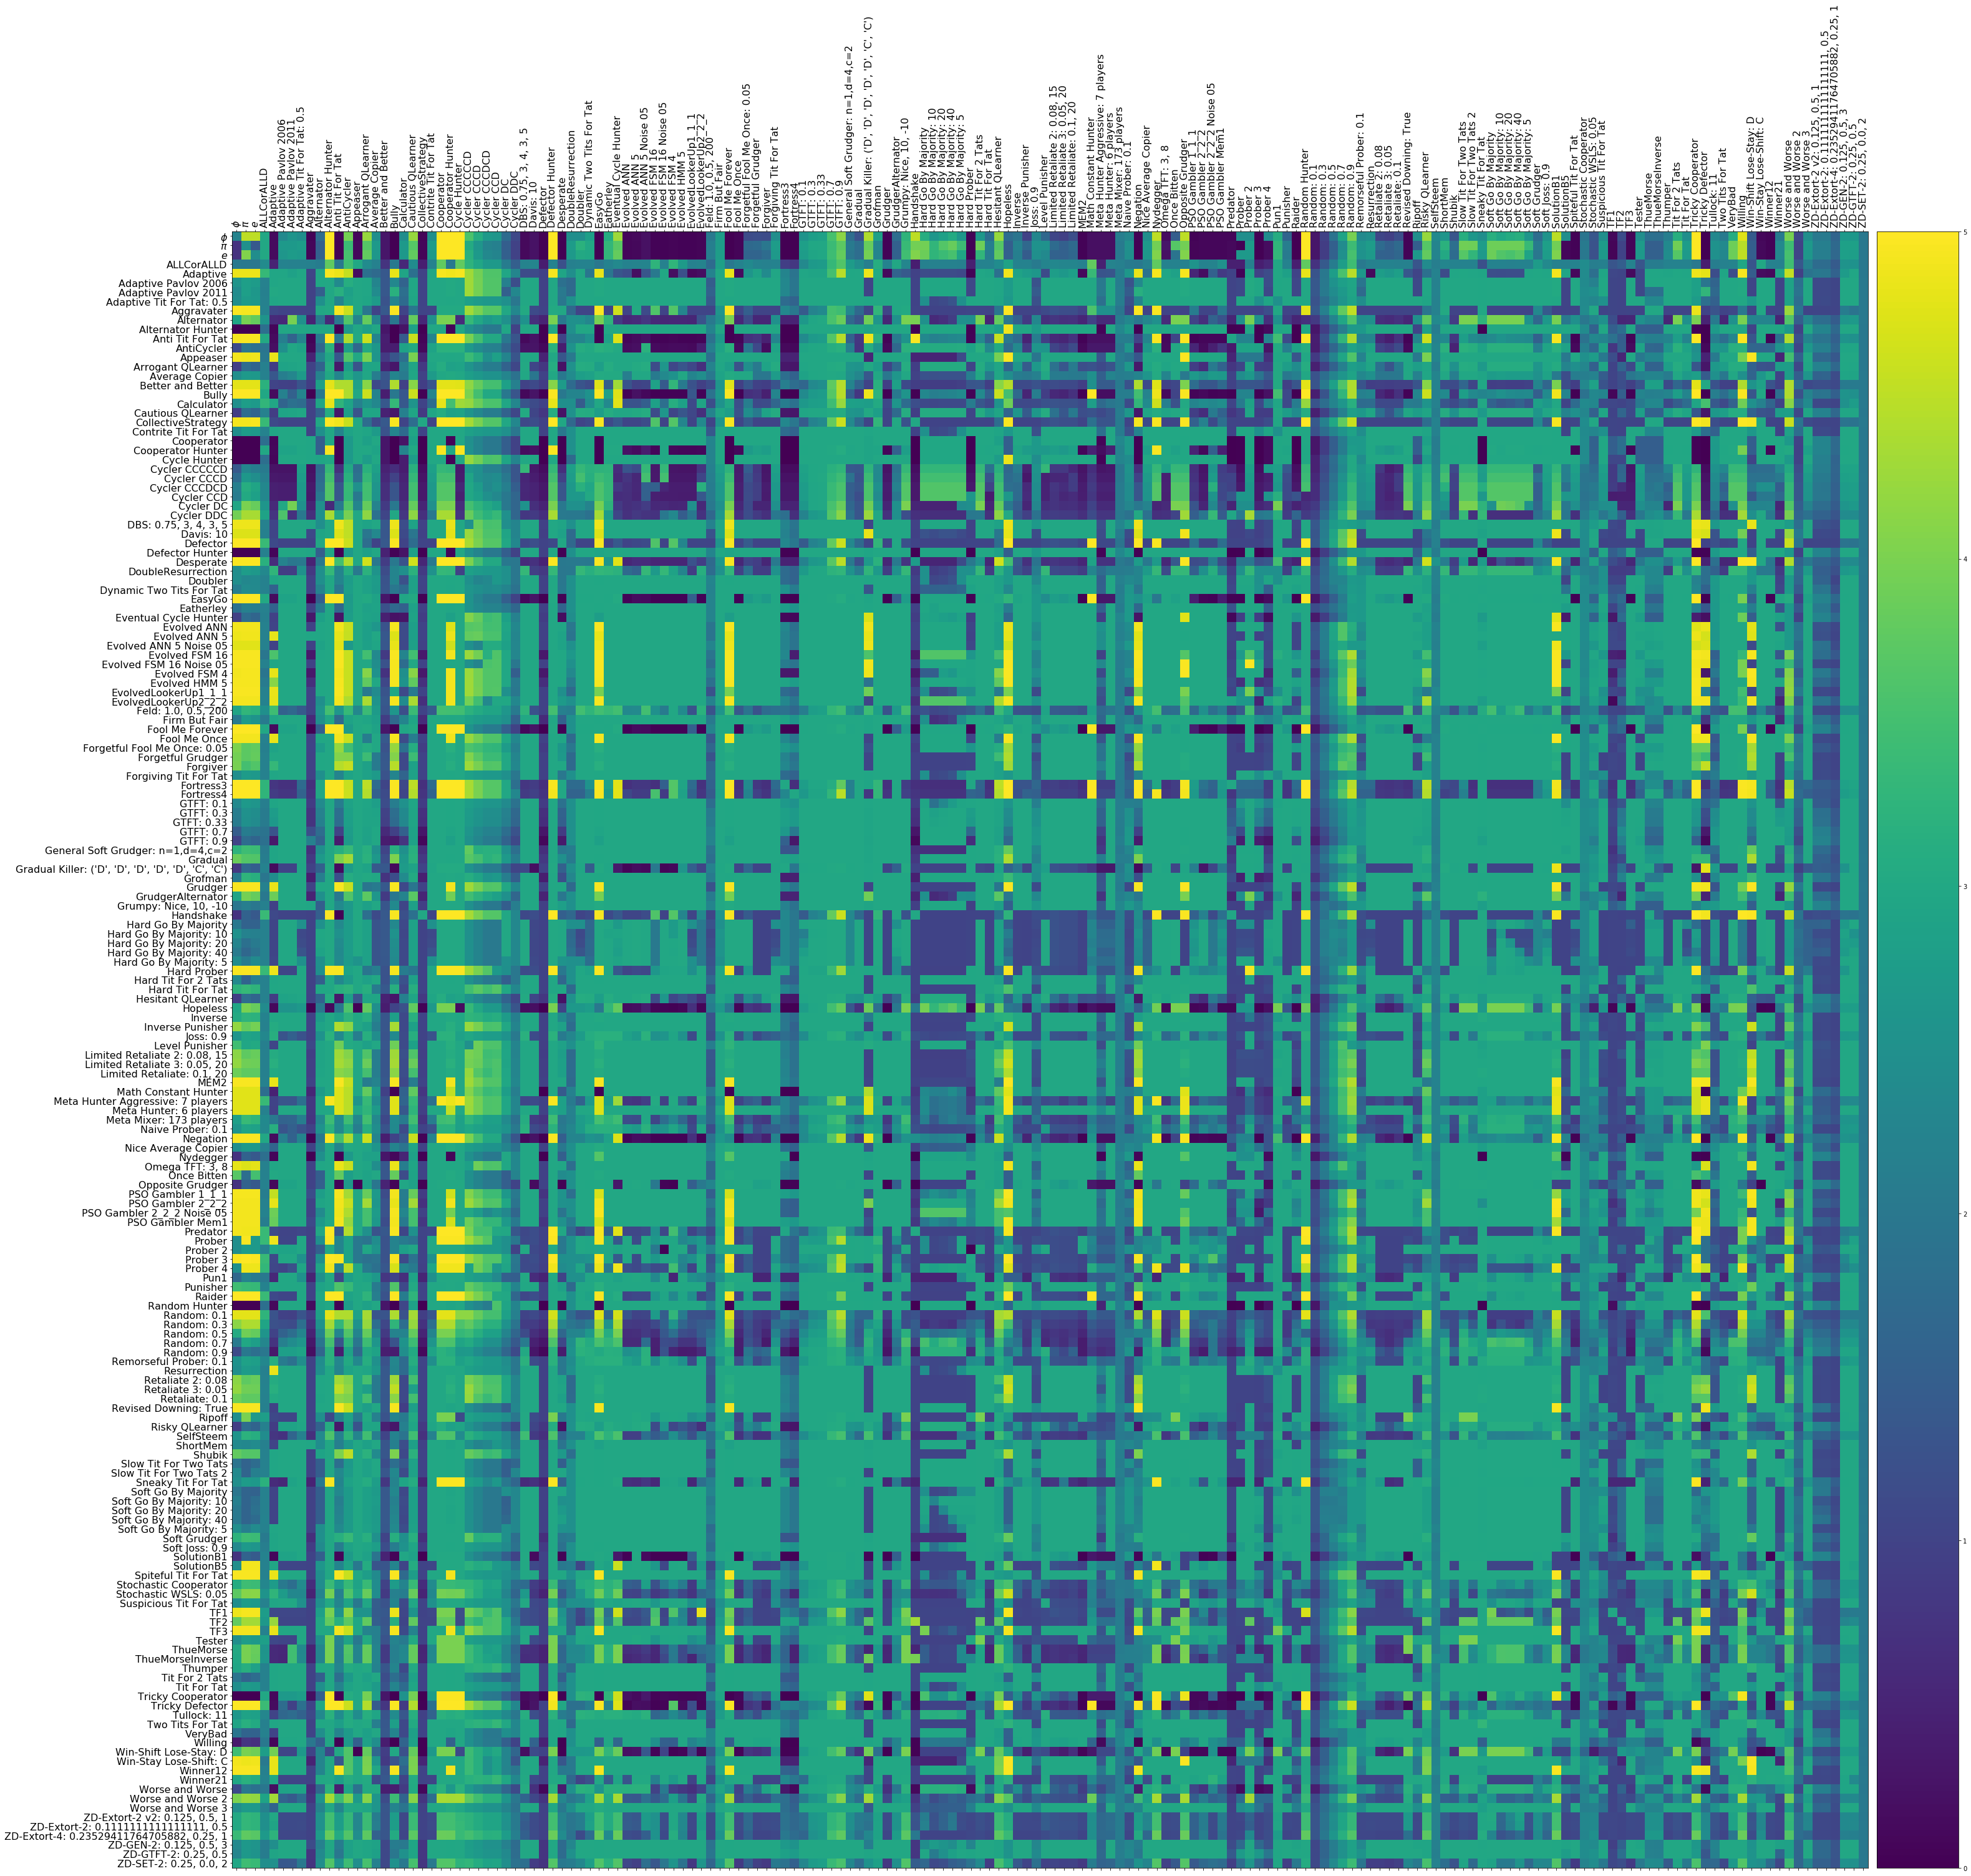

In [11]:
def payoff_heatmap(matrix, filename):
    fig, ax = plt.subplots()
    width = number_of_players / 4
    height = width
    spacing = 4 
    fig.set_size_inches(width, height) 

    mat = ax.matshow(payoff_matrix)

    ax.set_xticks(range(number_of_players))
    ax.set_yticks(range(number_of_players))
    ax.set_xticklabels(player_names, rotation=90)
    ax.set_yticklabels(player_names)
    ax.tick_params(axis='both', which='both', labelsize=16) 

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    fig.colorbar(mat, cax=cax)

    fig.tight_layout()
    fig.savefig(filename);
    
payoff_heatmap(payoff_matrix, "../assets/standard_scores_heatmap.pdf")

## Head to head wins

In [12]:
def read_wins(files):
    dfs = []
    for gz in files:
        if "wins" in gz:
            dfs.append(pd.read_csv(gz, header=None, names=player_names))
    df = pd.concat(dfs)
    return df

In [13]:
wins = read_wins(files=standard_files)

In [14]:
def summarise_wins(wins, score_summary):
    df = wins.describe(percentiles=[0.05, .25, .5, .75, .95]).transpose()
    df = df.sort_values("50%", ascending=False)  # Sorted on the median
    for var in ["count", "min", "max"]:
        df[var] = df[var].astype(int)
    return df.loc[score_summary.index]

win_summary = summarise_wins(wins, score_summary)
win_summary.head(15)

,count,mean,std,min,5%,25%,50%,75%,95%,max
EvolvedLookerUp2_2_2,15000,48.261667,1.335159,43,46.0,47.0,48.0,49.0,50.0,53
Evolved HMM 5,15000,41.348933,1.225104,37,39.0,41.0,41.0,42.0,43.0,45
Evolved FSM 16,15000,56.973133,1.102222,51,55.0,56.0,57.0,58.0,59.0,60
PSO Gambler 2_2_2,15000,40.677067,1.085384,36,39.0,40.0,41.0,41.0,42.0,44
Evolved FSM 16 Noise 05,15000,40.074600,1.677346,34,37.0,39.0,40.0,41.0,43.0,47
PSO Gambler 1_1_1,15000,44.979667,1.597443,39,42.0,44.0,45.0,46.0,48.0,51
Evolved ANN 5,15000,43.221667,0.673519,41,42.0,43.0,43.0,44.0,44.0,47
Evolved FSM 4,15000,37.230333,0.951003,35,36.0,37.0,37.0,38.0,39.0,41
Evolved ANN,15000,43.107800,1.021428,40,42.0,42.0,43.0,44.0,45.0,48
PSO Gambler Mem1,15000,43.465600,1.831276,37,40.0,42.0,44.0,45.0,46.0,49


In [15]:
# Write the top 15 players to a tex table
with open("../assets/standard_top_15_wins_summary.tex", "w") as f:
    f.write(clean_latex(win_summary.head(15).round(number_of_digits).to_latex()))

# Study the noisy tournaments


## Scores

In [16]:
noisy_files = glob.glob("./data/*_5_1000*gz")
scores = read_scores(files=noisy_files)

In [17]:
score_summary = summarise_scores(scores)
score_summary.head(15)

,count,mean,std,min,5%,25%,50%,75%,95%,max
"DBS: 0.75, 3, 4, 3, 5",15000,2.572830,0.024499,2.483114,2.533284,2.556250,2.572900,2.589057,2.613316,2.667343
Evolved ANN 5 Noise 05,15000,2.533738,0.025207,2.417857,2.491657,2.517221,2.534286,2.550886,2.574860,2.629000
Evolved FSM 16 Noise 05,15000,2.514985,0.030976,2.374400,2.463970,2.494029,2.515057,2.536057,2.565857,2.642143
Evolved ANN 5,15000,2.409251,0.030329,2.296714,2.359141,2.388914,2.409286,2.429800,2.458600,2.535771
Evolved FSM 4,15000,2.392650,0.027114,2.286343,2.348656,2.374086,2.392571,2.410950,2.437457,2.492943
Evolved HMM 5,15000,2.391694,0.026124,2.290886,2.348771,2.373914,2.391886,2.409286,2.434859,2.492200
Level Punisher,15000,2.388635,0.025064,2.290229,2.347429,2.371771,2.388771,2.405571,2.429143,2.487286
"Omega TFT: 3, 8",15000,2.386708,0.026138,2.269514,2.343400,2.369257,2.387086,2.404314,2.428630,2.489686
Spiteful Tit For Tat,15000,2.382871,0.029577,2.259200,2.334427,2.362886,2.383057,2.402743,2.431601,2.487714
Evolved FSM 16,15000,2.374908,0.029446,2.256343,2.326027,2.355257,2.375171,2.394971,2.422859,2.494343


In [18]:
# Write the top 15 players to a tex table
with open("../assets/noisy_top_15_scores_summary.tex", "w") as f:
    f.write(clean_latex(score_summary.head(15).round(number_of_digits).to_latex()))

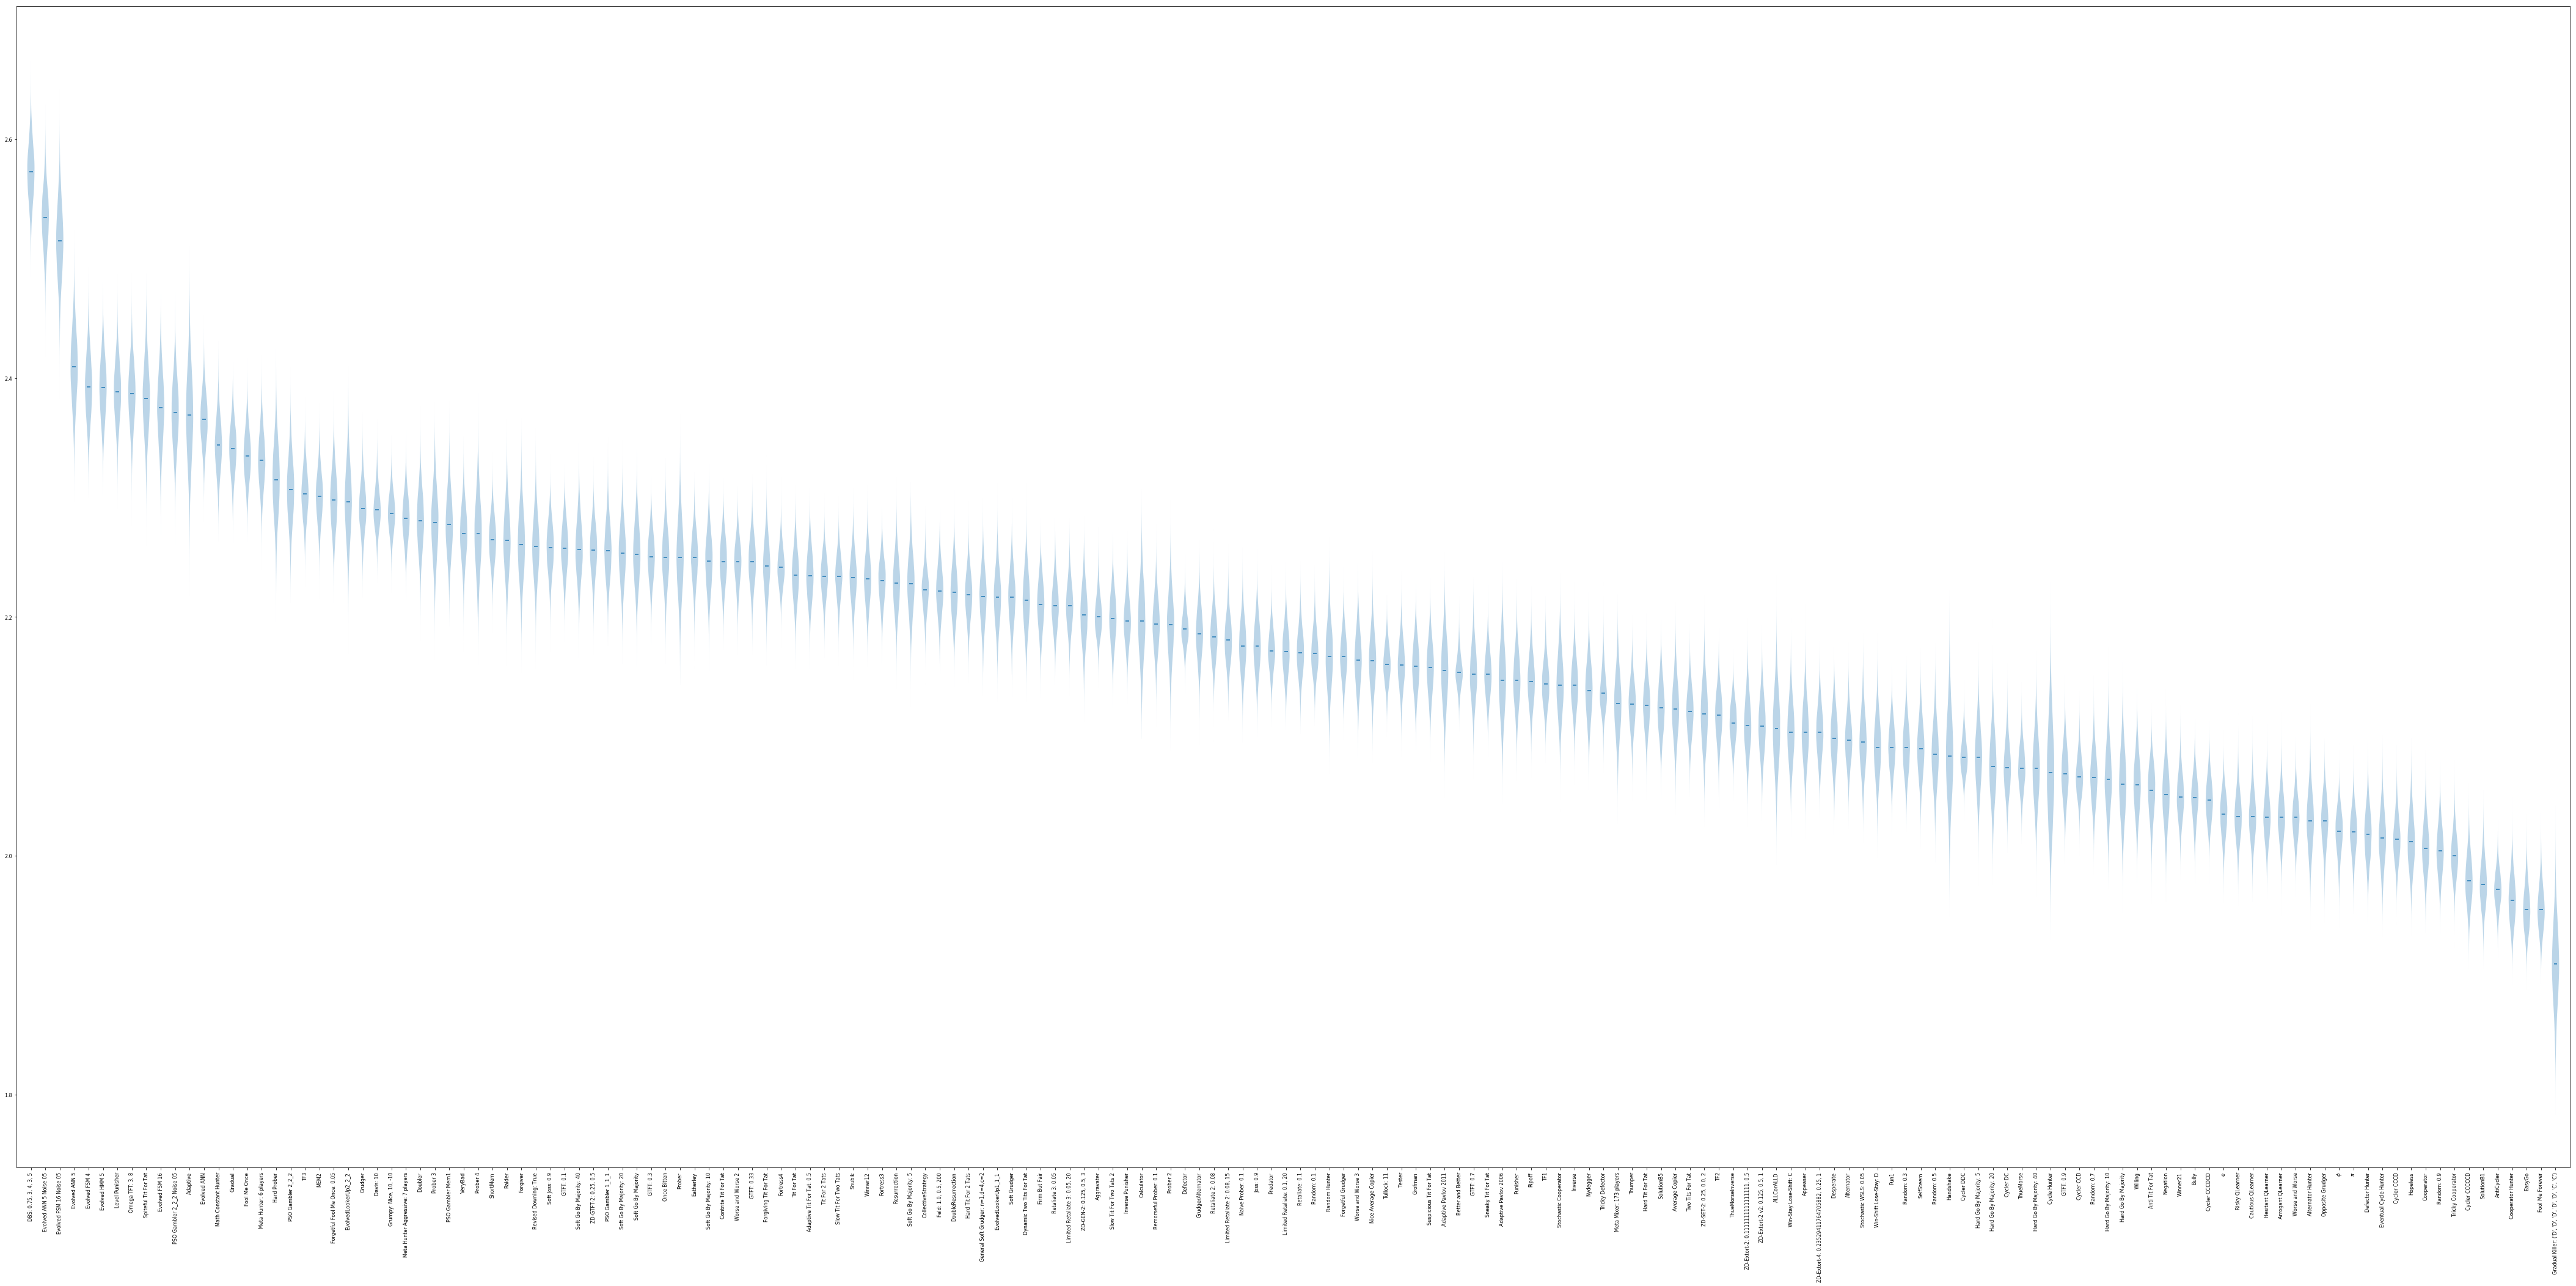

In [19]:
violon_plot(scores, "../assets/noisy_scores_boxplots.pdf")

## Ranks

In [20]:
rank_summary = summarise_ranks(scores)
rank_summary.head(15)

,count,mean,std,min,5%,25%,50%,75%,95%,max
"DBS: 0.75, 3, 4, 3, 5",15000,1.207733,0.471340,1,1.0,1.0,1.0,1.0,2.0,3
Evolved ANN 5 Noise 05,15000,2.186167,0.627921,1,1.0,2.0,2.0,3.0,3.0,5
Evolved FSM 16 Noise 05,15000,2.621200,0.624796,1,1.0,2.0,3.0,3.0,3.0,9
Evolved ANN 5,15000,6.379500,2.791836,2,4.0,4.0,5.0,8.0,12.0,24
Evolved FSM 4,15000,7.920167,3.186208,3,4.0,5.0,7.0,10.0,14.0,33
Evolved HMM 5,15000,7.987067,3.111256,3,4.0,5.5,7.0,10.0,14.0,24
Level Punisher,15000,8.298633,3.093543,3,4.0,6.0,8.0,10.0,14.0,26
"Omega TFT: 3, 8",15000,8.562300,3.279622,3,4.0,6.0,8.0,11.0,15.0,32
Spiteful Tit For Tat,15000,9.184967,3.781705,3,4.0,6.0,9.0,12.0,16.0,39
Evolved FSM 16,15000,10.210300,4.092966,3,4.0,7.0,10.0,13.0,17.0,42


In [21]:
# Write the top 15 players to a tex table
with open("../assets/noisy_top_15_ranks_summary.tex", "w") as f:
    f.write(clean_latex(rank_summary.head(15).round(number_of_digits).to_latex()))

## Payoff matrix

In [22]:
payoff_matrix = read_payoff_matrix(files=noisy_files)
assert payoff_matrix.shape == (176, 176)

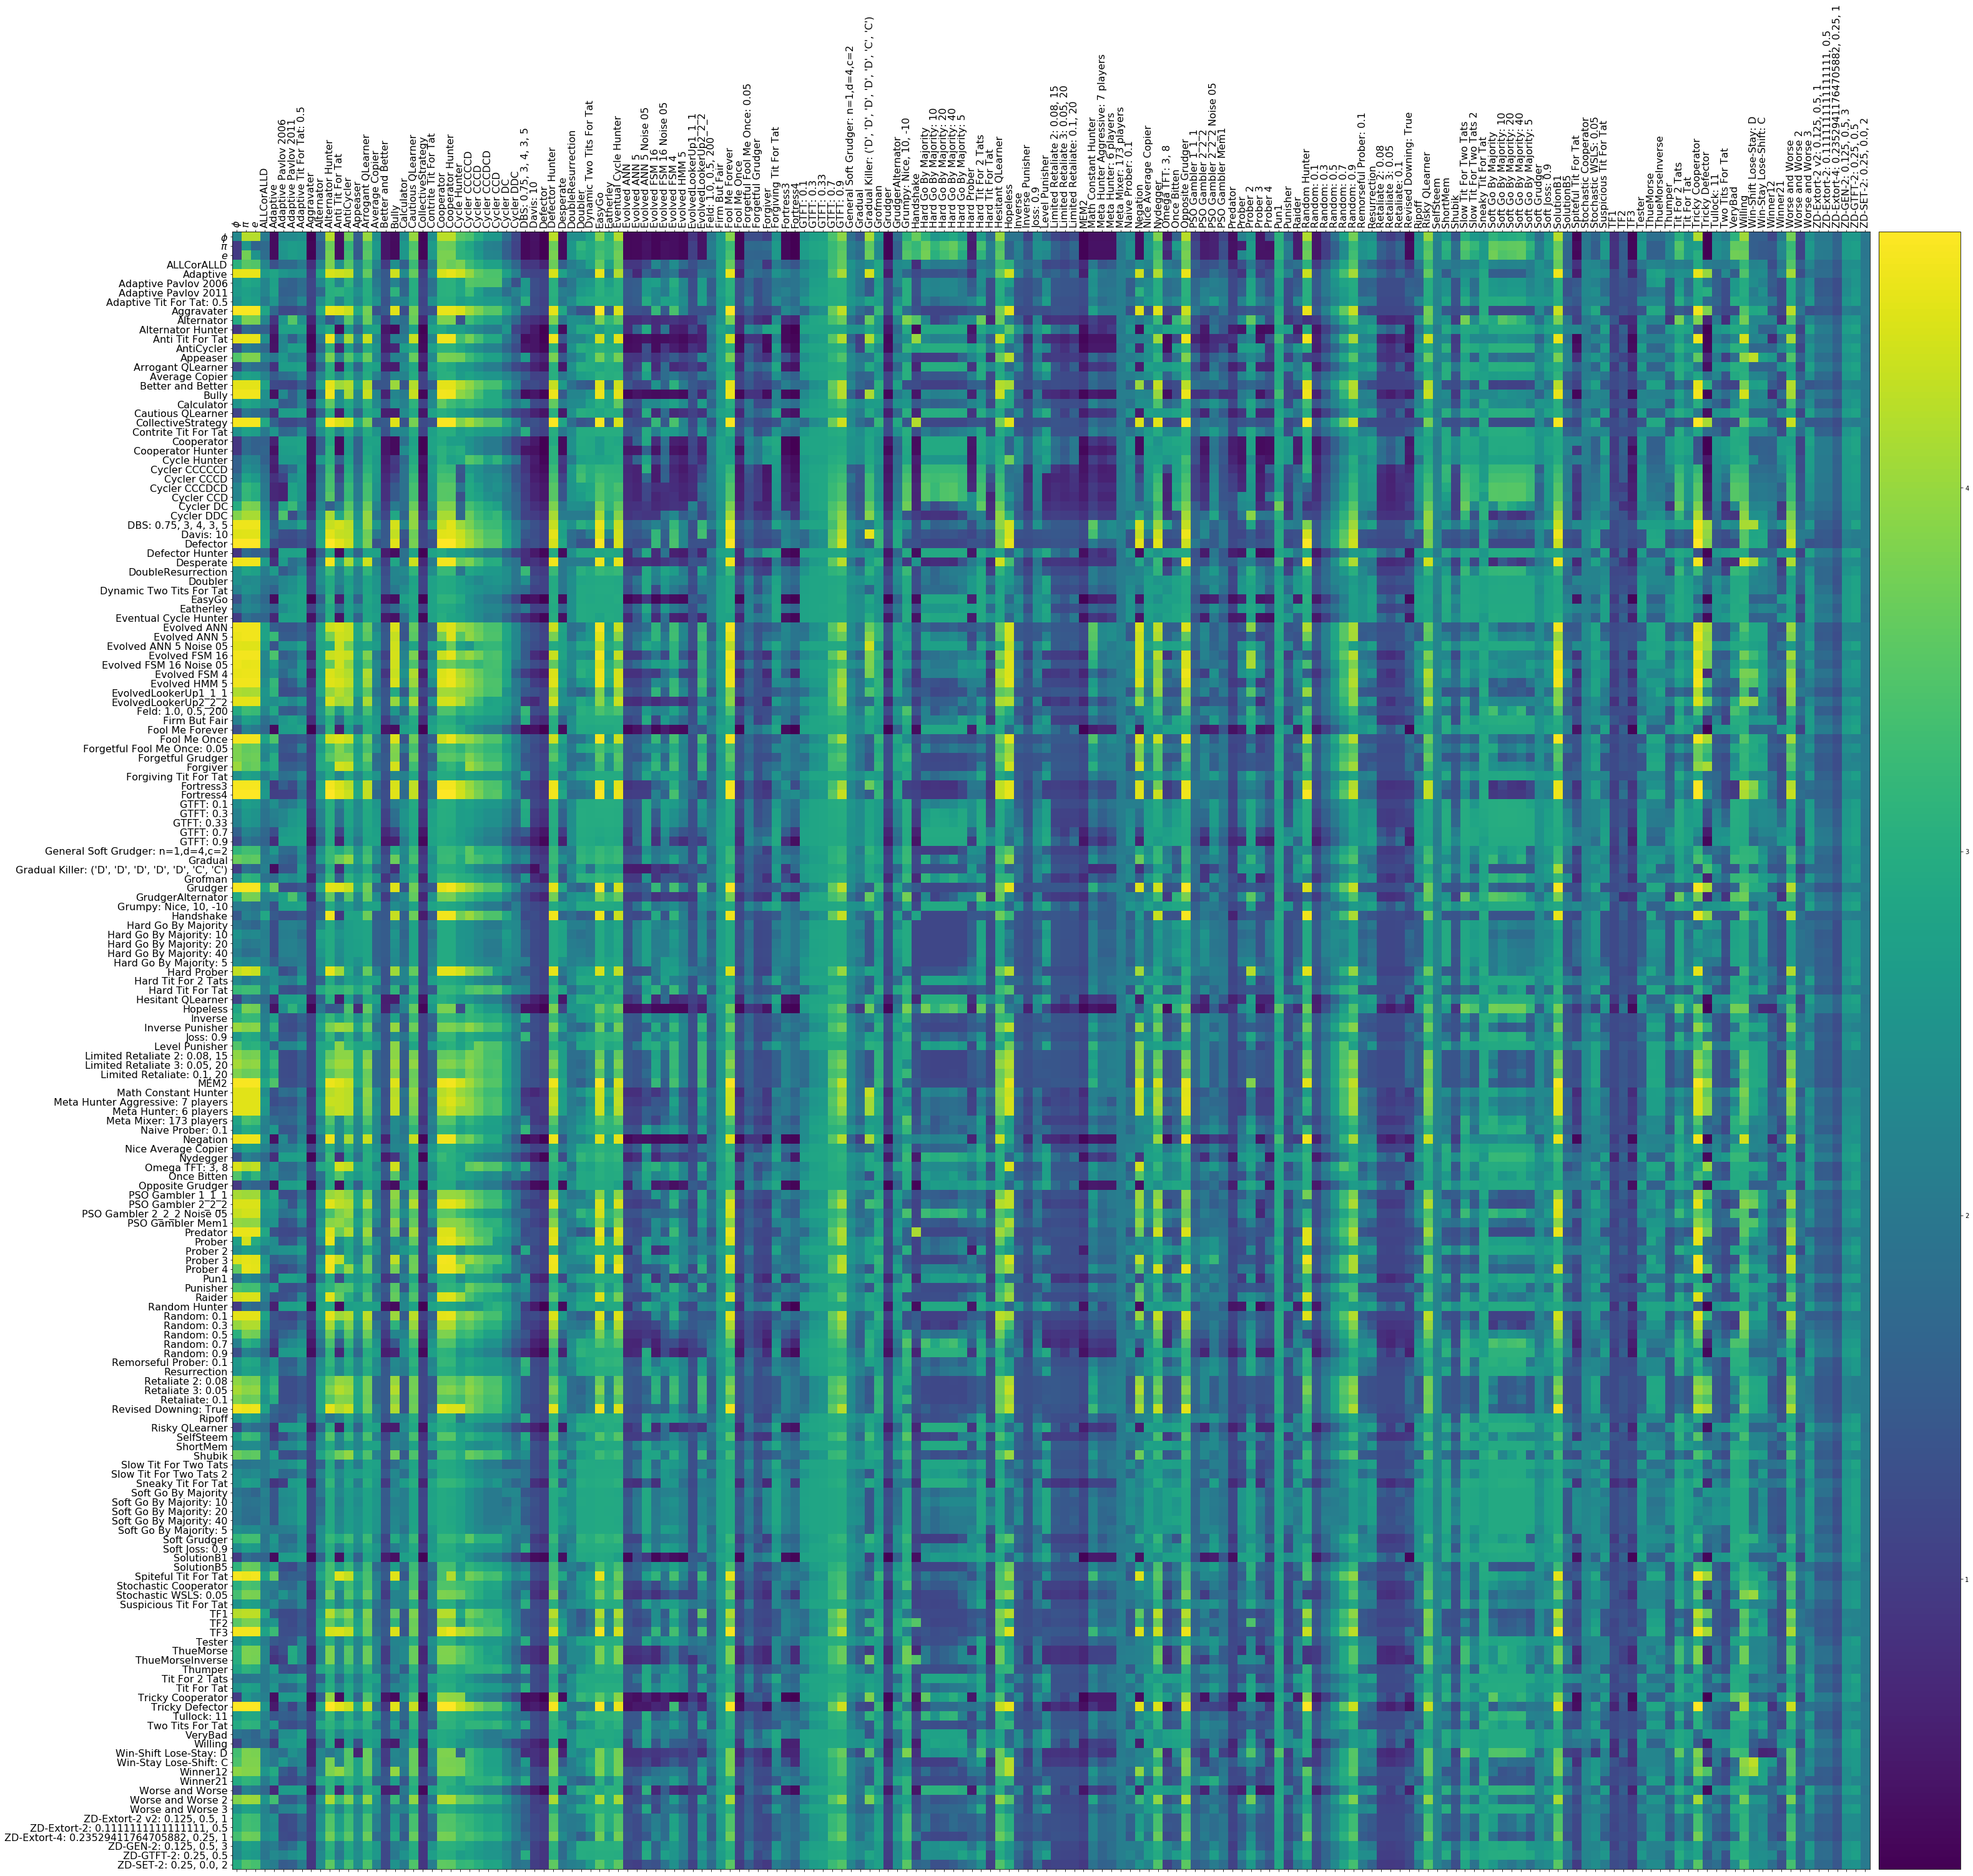

In [23]:
payoff_heatmap(payoff_matrix, "../assets/noisy_scores_heatmap.pdf")

## Wins

In [24]:
wins = read_wins(files=noisy_files)

In [25]:
win_summary = summarise_wins(wins, score_summary)
win_summary.head(15)

,count,mean,std,min,5%,25%,50%,75%,95%,max
"DBS: 0.75, 3, 4, 3, 5",15000,102.537000,3.701109,87,97.0,100.0,102.0,105.0,109.0,118
Evolved ANN 5 Noise 05,15000,75.057600,4.221217,59,68.0,72.0,75.0,78.0,82.0,93
Evolved FSM 16 Noise 05,15000,88.735600,3.862834,75,82.0,86.0,89.0,91.0,95.0,104
Evolved ANN 5,15000,137.839467,4.396747,118,131.0,135.0,138.0,141.0,145.0,154
Evolved FSM 4,15000,74.211867,2.694685,64,70.0,72.0,74.0,76.0,79.0,84
Evolved HMM 5,15000,88.228867,2.773025,78,84.0,86.0,88.0,90.0,93.0,99
Level Punisher,15000,94.234867,4.726069,77,86.0,91.0,94.0,97.0,102.0,112
"Omega TFT: 3, 8",15000,131.690067,4.304669,112,125.0,129.0,132.0,135.0,139.0,148
Spiteful Tit For Tat,15000,155.079333,3.319343,142,150.0,153.0,155.0,157.0,160.0,167
Evolved FSM 16,15000,103.295600,3.641580,89,97.0,101.0,103.0,106.0,109.0,118


In [28]:
# Write the top 15 players to a tex table
with open("../assets/noisy_top_15_wins_summary.tex", "w") as f:
    f.write(clean_latex(win_summary.head(15).round(number_of_digits).to_latex()))